Loaded 0 class
Loaded 1 class
Loaded 2 class
Loaded 3 class
Loaded 4 class
Loaded 5 class
Loaded 6 class
Loaded 7 class
Loaded 8 class
Loaded 9 class
After reshaping
(60000, 784) (60000, 10)
Epoch: 0, Loss: 2.4320325544426646, Val Loss: 2.405459412882832
Epoch: 1, Loss: 2.4022332262492916, Val Loss: 2.376691805558635
Epoch: 2, Loss: 2.373712136037782, Val Loss: 2.349071533024653
Epoch: 3, Loss: 2.346321963959488, Val Loss: 2.3224880060598148
Epoch: 4, Loss: 2.3199389500780723, Val Loss: 2.296839597424969
Epoch: 5, Loss: 2.2944703187899322, Val Loss: 2.272039369408799
Epoch: 6, Loss: 2.2698397502393477, Val Loss: 2.2480106181091677
Epoch: 7, Loss: 2.245978691821814, Val Loss: 2.2246794604333218
Epoch: 8, Loss: 2.2228212612671387, Val Loss: 2.202006460152083
Epoch: 9, Loss: 2.200325848057461, Val Loss: 2.179949521787681
Epoch: 10, Loss: 2.178441477768581, Val Loss: 2.158464978792346
Epoch: 11, Loss: 2.1571192350148443, Val Loss: 2.1375205652508806
Epoch: 12, Loss: 2.1363325358045495, Val

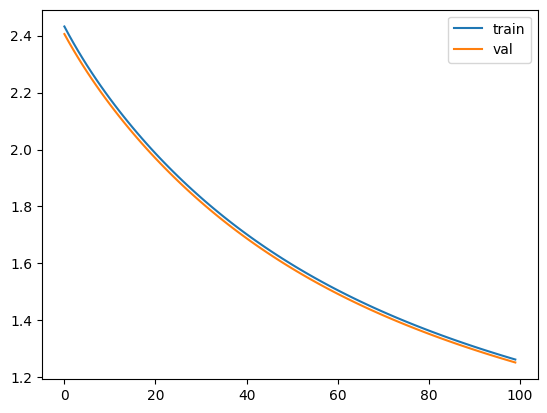

Accuracy: 0.6415


In [1]:
import os, numpy as np, matplotlib.pyplot as plt
folder = "./final/"

def load_data(X, y):
    for f in os.listdir(folder):
        if f.startswith('.'):
            continue
        for file in os.listdir(f"{folder}/{f}"):
            img = plt.imread(f"{folder}/{f}/{file}")
            X.append(img)
            label = [0] * 10
            label[int(f)] = 1
            y.append(label)
        print(f"Loaded {f} class")

X, y = [], []
load_data(X, y)

X = np.array(X)
y = np.array(y)

X = X[:, :,:, 0]
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
print("After reshaping")
print(X.shape, y.shape)

class NN:
    def __init__(self, input_neurons, hidden_neurons, output_neurons, learning_rate, epochs):
        self.input_neurons = input_neurons
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.epochs = epochs
        self.lr = learning_rate
        self.wih = np.random.randn(hidden_neurons, input_neurons) * np.sqrt(2/input_neurons)
        self.bih = np.zeros((hidden_neurons, 1))
        self.who = np.random.randn(output_neurons, hidden_neurons) * np.sqrt(2/hidden_neurons)
        self.bho = np.zeros((output_neurons, 1))

    def relu(self, z):
        return z * (z > 0)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def relu_derivative(self, z):
        return 1 * (z > 0)

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def softmax(self, z):
        z_stable = z - np.max(z, axis=0, keepdims=True)
        return np.exp(z_stable) / np.sum(np.exp(z_stable), axis=0, keepdims=True)

    def softmax_derivative(self, z):
        return z * (1 - z)

    def mean_squared_error(self, y, y_hat):
        return np.mean((y - y_hat) ** 2, axis=0)

    def cross_entropy_loss(self, y, y_hat):
        epsilon = 1e-15
        y_hat_clipped = np.clip(y_hat, epsilon, 1 - epsilon)
        return -np.sum(y * np.log(y_hat_clipped), axis=0)

    def mean_squared_error_derivative(self, y, y_hat):
        return y_hat - y

    def cross_entropy_derivative(self, y, y_hat):
        return y_hat - y

    def forward(self, input_list):
        inputs = np.array(input_list, ndmin=2).T
        inputs = inputs - np.mean(inputs)
        hidden_inputs = np.dot(self.wih, inputs) + self.bih
        hidden_outputs = self.relu(hidden_inputs)
        final_inputs = np.dot(self.who, hidden_outputs) + self.bho
        final_outputs = self.softmax(final_inputs)
        return final_outputs

    def backprop(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        inputs = inputs - np.mean(inputs)
        tj = np.array(targets_list, ndmin=2).T
        hidden_inputs = np.dot(self.wih, inputs) + self.bih
        hidden_outputs = self.relu(hidden_inputs)
        final_inputs = np.dot(self.who, hidden_outputs) + self.bho
        yj = self.softmax(final_inputs)
        loss = self.cross_entropy_loss(tj, yj)
        dE_dzo = self.cross_entropy_derivative(tj, yj)
        dE_dwho = np.dot(dE_dzo, hidden_outputs.T) / hidden_outputs.shape[1]
        dE_dbho = np.mean(dE_dzo, axis=1, keepdims=True)
        self.who -= self.lr * dE_dwho
        self.bho -= self.lr * dE_dbho
        dE_dah = np.dot(self.who.T, dE_dzo)
        dE_dzh = dE_dah * self.relu_derivative(hidden_inputs)
        dE_dwih = np.dot(dE_dzh, inputs.T) / inputs.shape[1]
        dE_dbih = np.mean(dE_dzh, axis=1, keepdims=True)
        self.wih -= self.lr * dE_dwih
        self.bih -= self.lr * dE_dbih
        return np.mean(loss)

    def fit(self, inputs_list, targets_list, validation_data, validation_labels):
        train_loss = []
        val_loss = []
        for epoch in range(self.epochs):
            loss = self.backprop(inputs_list, targets_list)
            train_loss.append(loss)
            val_predictions = self.forward(validation_data)
            vloss = self.cross_entropy_loss(validation_labels.T, val_predictions)
            val_loss.append(np.mean(vloss))
            print(f"Epoch: {epoch}, Loss: {loss}, Val Loss: {val_loss[-1]}")
        return train_loss, val_loss 

    def predict(self, X):
        outputs = self.forward(X).T
        return outputs

fashion_mnist = NN(784, 128, 10, 0.01, 100)
p = np.random.permutation(len(X))
X, y = X[p], y[p]

X_train, y_train = X[:int(0.7*len(X))], y[:int(0.7*len(X))]
X_val, y_val = X[int(0.7*len(X)):int(0.9*len(X))], y[int(0.7*len(X)):int(0.9*len(X))]
X_test, y_test = X[int(0.9*len(X)):], y[int(0.9*len(X)):]

train_loss, val_loss = fashion_mnist.fit(X_train, y_train, X_val, y_val)

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

y_pred = fashion_mnist.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  
y_test = np.argmax(y_test, axis=1)
print(f"Accuracy: {np.mean(y_pred == y_test)}")
